In [1]:
from matplotlib import pyplot as plt
from os.path import join
from helpers.utils import load_val_log, get_pareto_mask
import pandas as pd
import numpy as np


# Output directory
out_dir = "outputs/"

## uSDR over epochs for the base model
Check the impact of the patience parameter onto convergence (figure 1 in the paper).

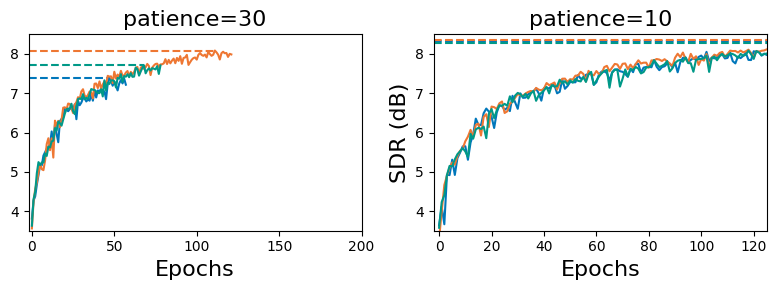

In [2]:
# High contrast, colorblind-friendly color palette
colors_list = [
    "#0077BB",
    "#EE7733",
    "#009988",
] 
seed_list = [1, 2, 3]

# Load the exp info log
exp_info = pd.read_csv(join(out_dir, "exp_infos.csv"))
exp_info = exp_info.reset_index()

# Prepare the figure
plt.figure(figsize=(8, 3))
xmin = -2

plt.subplot(1, 2, 1)
for i, s in enumerate(seed_list):
    exp_name = "bsrnn-seed=" + str(s) + "-vocals"
    df = exp_info.loc[exp_info["exp_name"] == exp_name]
    version_list = list(df["tb_version"])
    tblogdir_model = df["tblog_dir"].iloc[0]

    best_sdr, idx_opt, df_valsdr, _, _ = load_val_log(version_list, tblogdir_model)
    plt.plot(df_valsdr, color=colors_list[i])
    plt.hlines(
        y=best_sdr,
        xmin=xmin,
        xmax=idx_opt,
        colors=colors_list[i],
        linestyles="dashed",
    )

plt.xlim([xmin, 200])
plt.ylim([3.5, 8.5])
plt.xlabel("Epochs", fontsize=16)
plt.title("patience=30", fontsize=16)

plt.subplot(1, 2, 2)
for i, s in enumerate(seed_list):
    exp_name = "bsrnn-patience=30-seed=" + str(s) + "-vocals"
    df = exp_info.loc[exp_info["exp_name"] == exp_name]
    version_list = list(df["tb_version"])
    tblogdir_model = df["tblog_dir"].iloc[0]

    best_sdr, idx_opt, df_valsdr, _, _ = load_val_log(version_list, tblogdir_model)
    plt.plot(df_valsdr, color=colors_list[i])
    plt.hlines(
        y=best_sdr,
        xmin=xmin,
        xmax=idx_opt,
        colors=colors_list[i],
        linestyles="dashed",
    )

plt.xlim([xmin, 125])
plt.ylim([3.5, 8.5])
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("SDR (dB)", fontsize=16)
plt.title("patience=10", fontsize=16)

plt.tight_layout()
plt.savefig(join(out_dir, "patience.eps"))
plt.savefig(join(out_dir, "patience.png"))


## Energy vs. performance

In [10]:
exp_list = [
    "bsrnn",
    "bsrnn-acc_grad=2",
    "bsrnn-monitor_val=loss",
    "bsrnn-loss_domain=t",
    "bsrnn-loss_domain=tf",
    "bsrnn-n_fft=4096-n_hop=1024",
    "bsrnn-fac_mask=2",
    "bsrnn-large",
    "bsrnn-large-patience=30",
    "bsrnn-stereo=naive",
    "bsrnn-stereo=naive-fac_mask=8",
    "bsrnn-stereo=tac",
    "bsrnn-stereo=tac-act_tac=prelu",
    "bscnn-feature_dim=64-num_repeat=8",
    "bsrnn-n_att_head=1-attn_enc_dim=8",
    "bsrnn-n_att_head=2-attn_enc_dim=16",
    "bsrnn-n_heads=2",
    "bsrnn-dset.aug_list=[random_chunk,random_track_mix,rescale_db,silenttarget]",
    "bsrnn-dset=musdb18hq",
    "bsrnn-opt-notac-dset=musdb18hq-patience=30",
    "bsrnn-opt-dset=musdb18hq-patience=30",
]
metric = "GA"

df_sdr = pd.read_csv(join(out_dir, "val_results_sdr.csv"), index_col=None)
df_energy = pd.read_csv(join(out_dir, "val_results_energy_" + metric + ".csv"), index_col=None)

sdr, energy = [], []
for exp_name in exp_list:
    sdr.append(df_sdr.loc[df_sdr["exp_name"] == exp_name]["song"].item())
    e = df_energy.loc[df_energy["exp_name"] == exp_name]["Total"].item()
    energy.append(e)

x = np.column_stack((energy, sdr))
mask = get_pareto_mask(x * [1, -1])

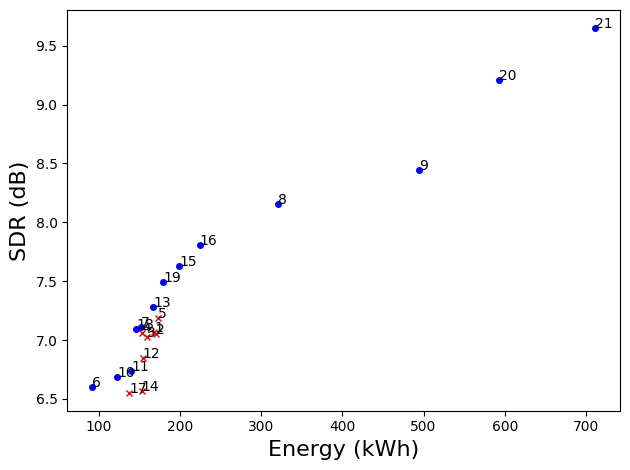

In [11]:
for i, a in enumerate(x):
    marker = "ob" if mask[i] else "xr"
    plt.plot(a[0], a[1], marker, markersize=4)
    plt.annotate(str(i+1), (energy[i], sdr[i]), fontsize=10)
plt.xlabel('Energy (kWh)', fontsize=16)
plt.ylabel('SDR (dB)', fontsize=16)

plt.tight_layout()
plt.savefig(join(out_dir, "pareto.eps"))
plt.savefig(join(out_dir, "pareto.png"))